<a href="https://colab.research.google.com/github/FelipeFerAl/TAM-2025-2/blob/main/Parciales/Parcial1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PARCIAL 1 DE TEORÍA DE APRENDIZAJE DE MÁQUINA 2025-2
#Felipe Fernández Alzate, Gabriela Romo Mendoza



---



#Punto #3:
Consulte en que consiste y el funcionamiento principal de la librería RAPIDS. Posteriormente, elabore una tabla que compare los metodos e hiperparámetros más relevantes de los regresores mencionados en el punto 2, indicando su implementación o el algoritmo equivalente disponible en RAPIDS.

##¿En qué consiste RAPIDS?
NVIDIA RAPIDS es un conjunto de bibliotecas de software de código abierto y API diseñadas para acelerar los procesos de ciencia de datos y análisis dependiendo únicamente de una GPU. Proporciona una interfaz similar a librerías de Python, como pandas, scikit-learn y NetworkX, lo que permite a los científicos de datos aprovechar la inmensa potencia de procesamiento paralelo de las GPU sin tener que aprender a utilizar herramientas completamente nuevas.

##¿Cómo es su funcionamiento?
Su objetivo principal es llevar la aceleración por GPU no solo al Deep Learning (lo que ya hacen marcos como TensorFlow o PyTorch), sino también a todo el flujo de trabajo de la ciencia de datos, incluyendo la carga de datos, la limpieza, la ingeniería de características y el aprendizaje automático clásico.



---



##¿Cómo se compara con los regresores ya vistos?
| **Regresor (scikit-learn)**            | **Hiperparámetros clave**                                                       | **Equivalente RAPIDS**                                                                | **Notas de Implementación**                                                                    |
| --------------------------------------- | ----------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------- |
| **LinearRegression**                    | `fit_intercept`, `normalize`, `copy_X`                                        | `cuml.LinearRegression`                                                                   | Totalmente compatible; solucionador OLS acelerado por GPU.                                                |
| **Lasso**                               | `alpha`, `max_iter`, `tol`, `selection`                                       | `cuml.Lasso`                                                                              | Utiliza descenso coordinado en GPU; equivalente a sklearn.                                      |
| **ElasticNet**                          | `alpha`, `l1_ratio`, `max_iter`, `tol`                                        | `cuml.ElasticNet`                                                                         | Implementación de GPU; combina penalizaciones L1 y L2.                                           |
| **KernelRidge**                         | `alpha`, `kernel`, `gamma`, `degree`, `coef0`                                 | ❌ *No Disponible*                                                                         | Aún no existe una versión directa de cuML; se puede aproximar mediante cuML SVR con kernel polinomial/RBF.        |
| **SGDRegressor**                        | `loss`, `penalty`, `alpha`, `learning_rate`, `max_iter`                       | ❌ *No Implementado*                                                                       | Actualmente, cuML carece de modelos lineales basados en SGD; se utiliza `LinearRegression` o `Ridge`.            |
| **BayesianRidge**                       | `alpha_1`, `alpha_2`, `lambda_1`, `lambda_2`                                  | ❌ *No Disponible*                                                                         | No hay versión cuML; el cálculo requiere muchas matrices, pero se puede acelerar manualmente con GPU mediante CuPy. |
| **GaussianProcessRegressor**            | `kernel`, `alpha`, `optimizer`, `n_restarts_optimizer`                        | ❌ *No Disponible*                                                                         | No hay versión GPU en cuML; se utiliza PyTorch o GPyTorch para procesos gaussianos basados en GPU.           |
| **Support Vector Regressor (SVR)**      | `C`, `kernel`, `gamma`, `epsilon`, `degree`                                   | `cuml.SVR`                                                                                | Implementación completa de GPU; admite kernels lineales, polinómicos y RBF.                            |
| **RandomForestRegressor**               | `n_estimators`, `max_depth`, `max_features`, `min_samples_split`              | `cuml.RandomForestRegressor`                                                              | Totalmente acelerado por GPU; muy rápido para grandes conjuntos de datos.                  |
| **GradientBoostingRegressor / XGBoost** | `n_estimators`, `learning_rate`, `max_depth`, `subsample`, `colsample_bytree` | `cuml.GradientBoostingRegressor` | RAPIDS ofrece el GBM nativo de cuML y también es compatible con el backend XGBoost GPU.                      |


#Punto #4.1: Análisis
Presente un analisis detallado del conjunto de datos disponible en https://www.kaggle.com/competitions/nfl-big-data-bowl-2026-prediction/overview. Incluya la descripcion de las variables de entrada y salida, el objetivo principal del concurso, un análisis exploratorio básico, los procedimientos de codificación de valores faltantes y variables categóricas, así como las estrategias de
ingeniería de características —si aplican—. Finalmente, proporcione todos los detalles necesarios para comprender, interpretar y analizar adecuadamente el conjunto de datos.


## Descripción
El dataset de la NFL 2026 es un conjunto de datos de las jugadas realizadas a lo largo de diferentes juegos en la temporada, su función principal es permitir la predicción de la posición de un jugador a lo largo de un frame de análisis tomando como base diferentes características como la velocidad, orientación, dirección de juego, posición actual del jugador, rol, entre otras. La salida del modelo debe entregar las variables target (posición X y Y de los jugadores) al momento de lanzar un balón.
Para esto, la tarea fundamental es crear un modelo de predicción de ubicación espacial y temporal al momento de analizar un frame de juego.

In [1]:
from IPython.display import clear_output

In [2]:
# === DESCARGA DEL DATASET DESDE DRIVE ===
!pip install gdown
import gdown
clear_output()

FILE_ID = "19nA4DAPsNwbVwbXrwrLBf2KiVYSgPaky"
OUTPUT_PATH = "data_2026.zip"

print("Downloading dataset...")
gdown.download(f"https://drive.google.com/uc?id={FILE_ID}", OUTPUT_PATH, quiet=False)
!unzip -q {OUTPUT_PATH} -d data_2026
print("✅ Dataset ready in data_2026/")

Downloading...
From (original): https://drive.google.com/uc?id=19nA4DAPsNwbVwbXrwrLBf2KiVYSgPaky
From (redirected): https://drive.google.com/uc?id=19nA4DAPsNwbVwbXrwrLBf2KiVYSgPaky&confirm=t&uuid=81b8a898-fe8b-4f71-9b76-3986128ca6a1
To: /content/data_2026.zip
100%|██████████| 107M/107M [00:02<00:00, 44.0MB/s] 


✅ Dataset ready in data_2026/


In [3]:
# Importar todas las librerias necesarias instalando RAPIDS en el entorno Colab
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py
clear_output()

In [23]:
import cudf
import cupy as cp
from cuml.preprocessing import LabelEncoder
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def load_training_data_gpu(data_path='/content/data_2026/train'):
  """
  Carga de la carpeta de entrenamiento por GPU.
  """
  print("\n" + "="*80)
  print("LOADING TRAINING DATA (GPU)")
  print("="*80)

  input_data = []
  output_data = []
  for week in range(1, 19):
      file_path = f'{data_path}/input_2023_w{week:02d}.csv'
      file_path2 = f'{data_path}/output_2023_w{week:02d}.csv'
      try:
          df = cudf.read_csv(file_path)   # Lectura de CSV acelerada
          df2 = cudf.read_csv(file_path2)
          input_data.append(df)
          output_data.append(df2)
      except FileNotFoundError:
          print(f"✗ Week {week:02d}: File not found")

  # Concatenar todos los datos en un solo dataframe por cuDF
  train_df = cudf.concat(input_data, ignore_index=True)
  targets = cudf.concat(output_data, ignore_index=True)
  print("DATA CORRECTLY LOADED")
  return train_df, targets

def encode_categorical_gpu(df):
  """
  Codifica columnas categóricas usando LabelEncoder de RAPIDS.
  Retorna un DataFrame de cuDF (usando GPU) y el mapeo (diccionario).
  """
  df = df.copy(deep=True)     # Copia de la base de datos
  categorical_cols = ['play_direction', 'player_position', 'player_side', 'player_role']      # Columnas categóricas

  #Inicializar diccionario de mapeo y codificadores
  mappings = {}
  encoders = {}

  for col in categorical_cols:
      le = LabelEncoder()
      # Transformación llevada a cabo por la GPU
      df[col] = le.fit_transform(df[col].astype('str'))

      # Almacenamiento de los datos
      encoders[col] = le
      classes = le.classes_.to_pandas()   # Conversión a Pandas para exportar datos
      mapping_values = list(range(len(classes)))
      mappings[col] = dict(zip(classes, mapping_values))

  return df, mappings, encoders

def dataset_cleaning(X, Y):
  """
  Limpieza de la base de datos y variables de salida.
  """
  df = X.copy(deep=True)     # Copia de la base de datos

  # Validación de datos del modelo, organización pareja de variables
  merged = df.merge(Y, on=['game_id', 'play_id', 'nfl_id', 'frame_id'], how='inner', suffixes=('_in', '_out'))

  features = merged.drop(columns=['x_out', 'y_out'])
  targets = merged[['x_out', 'y_out']]

  unnecessary_columns = ['player_birth_date', 'player_name', 'nfl_id', 'game_id', 'num_frames_output', 'player_to_predict', 'player_height']
  features = features.drop(columns=unnecessary_columns)
  return features, targets

def new_data(df):
  """
  Creación de nuevas características
  """
  df = df.copy(deep=True)     # Copia de la base de datos
  # Distancia al balón
  df['dist_ball'] = cp.sqrt((df['x_in'] - df['ball_land_x'])**2 +
                                  (df['y_in'] - df['ball_land_y'])**2)
  # Momentum
  df['momentum'] = df['player_weight'] * df['s']
  return df

##Ingenieria de características
Entre los procesos más comunes y aplicados a este código para la limpieza de la base datos encontramos:
* **Asimilación de datos**: No todas las salidas estaban emparejadas con la base de datos sabiendo que había una característica denotada como "player_to_predict", en base a esta reducimos la dimensión del dataset para que cada entrada tenga su respectiva salida, filtrando y uniendo cada fila
* **Transformación de variables categóricas:** Tomando en cuenta la información dada al tomar el dataframe original, observamos ciertos parámetros relevantes de tipo object como: player_position, player_role, player_side o player_direction. Para mantener estos datos y darles un buen uso al momento de visualizar y analizar diferentes comportamientos de los mismos, los pasamos por un codificador que los transformará a variables numéricas según un mapeo dado.
* **Eliminiación de columnas no necesarias**: No todo el conjunto de características en un dataset puede ser relevante al momento de generar un modelo, por lo que se plantean ciertos datos innecesarios que serán eliminados del dataframe por medio del comando: _dataset_.drop(_columnas no deseadas_)
* **Creación de nuevas características**: Aunque el dataset no proporcione información que tal vez sea relevante, con lo que tenemos podemos crear nuevas características para los datos que podrían ayudar en la creación del modelo de predicción. Esto se basa en conceptos físicos o parámetros influyentes en la posición del jugador

In [5]:
X, Y = load_training_data_gpu()


LOADING TRAINING DATA (GPU)
DATA CORRECTLY LOADED


In [6]:
X2, mappings, encoders = encode_categorical_gpu(X)

In [24]:
train_clean, targets = dataset_cleaning(X2, Y)
train_full = new_data(train_clean)

In [32]:
# Información de la base de datos
train_full.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 560426 entries, 0 to 560425
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   play_id                   560426 non-null  int64
 1   frame_id                  560426 non-null  int64
 2   play_direction            560426 non-null  uint8
 3   absolute_yardline_number  560426 non-null  int64
 4   player_weight             560426 non-null  int64
 5   player_position           560426 non-null  uint8
 6   player_side               560426 non-null  uint8
 7   player_role               560426 non-null  uint8
 8   x_in                      560426 non-null  float64
 9   y_in                      560426 non-null  float64
 10  s                         560426 non-null  float64
 11  a                         560426 non-null  float64
 12  dir                       560426 non-null  float64
 13  o                         560426 non-null  float64
 14  ball_l

##Análisis exploratorio:
Lo mejor que se puede realizar es visualizar el comportamiento de ciertos datos para entender su importancia en el dataset y plantear diferentes modos de uso para los mismos.
Para los casos siguientes, podemos notar diagramas de barras con algunas características con comportamiento de señal Normal o algunas características bimodales o con picos muy grandes.
Esto será relevante al momento de elegir variables necesarias para el entrenamiento de nuestro modelo.

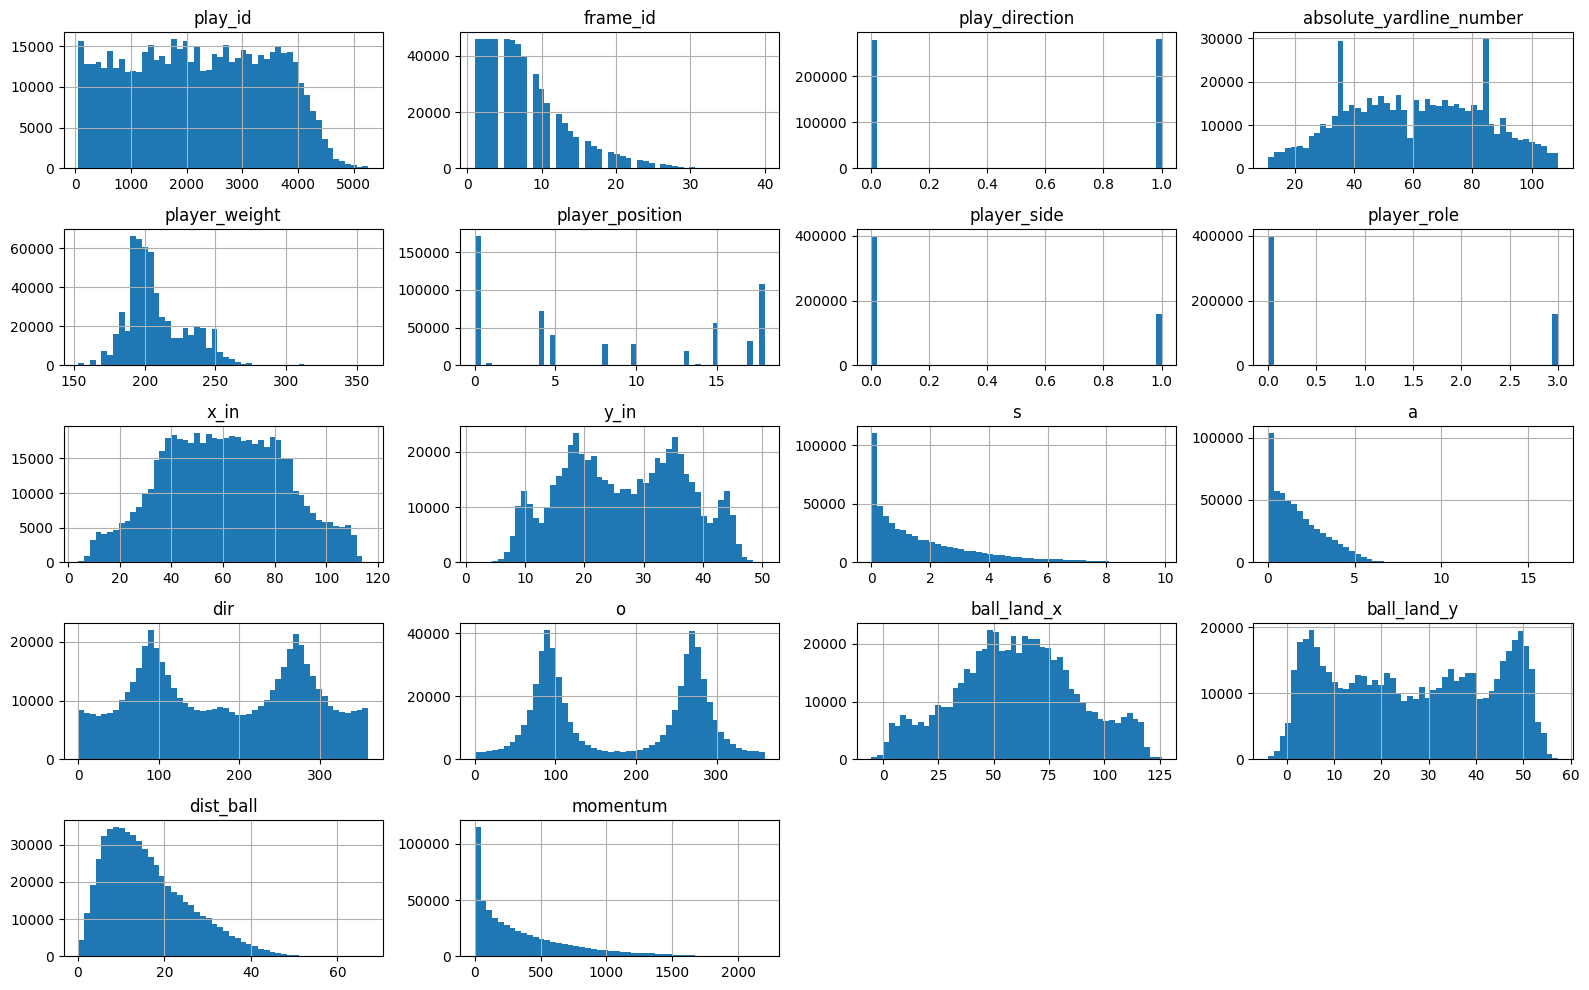

In [9]:
import matplotlib.pyplot as plt

# Convertir cuDF → Pandas (Facilidad de impresión)
train_df_cpu = train_full.to_pandas()

train_df_cpu.hist(bins=50, figsize=(16,10))
plt.tight_layout()
plt.show()

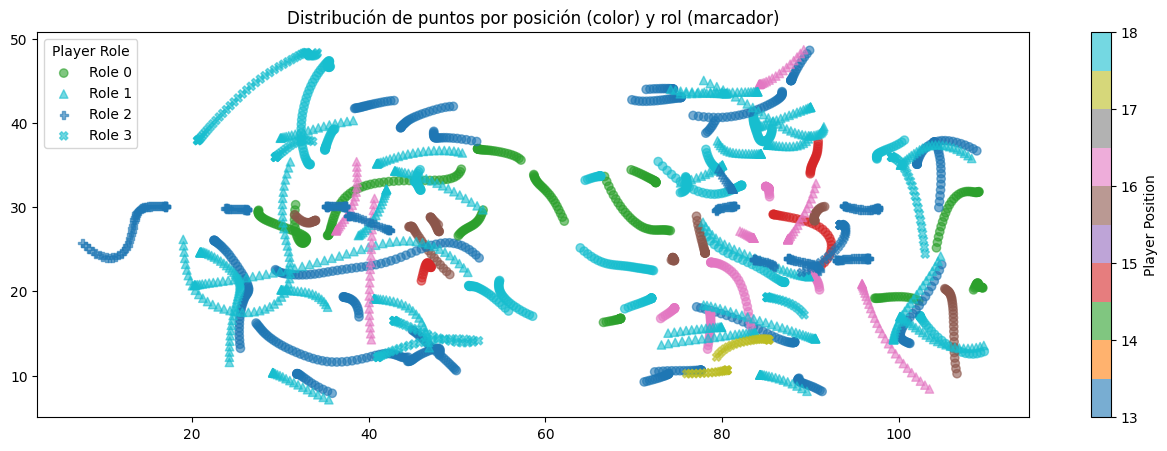

Roles: {'Defensive Coverage': 0, 'Other Route Runner': 1, 'Passer': 2, 'Targeted Receiver': 3}
Posiciones: {'CB': 0, 'DE': 1, 'DT': 2, 'FB': 3, 'FS': 4, 'ILB': 5, 'K': 6, 'LB': 7, 'MLB': 8, 'NT': 9, 'OLB': 10, 'P': 11, 'QB': 12, 'RB': 13, 'S': 14, 'SS': 15, 'T': 16, 'TE': 17, 'WR': 18}


In [10]:
"""
En la siguiente gráfica se visualiza las posiciones de una pequeña muestra de los jugadores
en base a su posición y rol en el equipo, esto es importante tomando en cuenta la distribución
de los mismos en base a la jugada a analizar
"""
subset = X2.iloc[0:3000].to_pandas()
markers = ["o", "^", "P", "X"]

plt.figure(figsize=(16,5))
for role_val in subset['player_role'].unique():
    role_subset = subset[subset['player_role'] == role_val]
    plt.scatter(
        role_subset['x'],
        role_subset['y'],
        c=role_subset['player_position'],
        cmap='tab10',
        marker=markers[role_val % len(markers)],
        alpha=0.6,
        label=f"Role {role_val}"
    )

plt.colorbar(label="Player Position")
plt.legend(title="Player Role")
plt.title("Distribución de puntos por posición (color) y rol (marcador)")
plt.show()

print(f"Roles: {mappings['player_role']}")
print(f"Posiciones: {mappings['player_position']}")

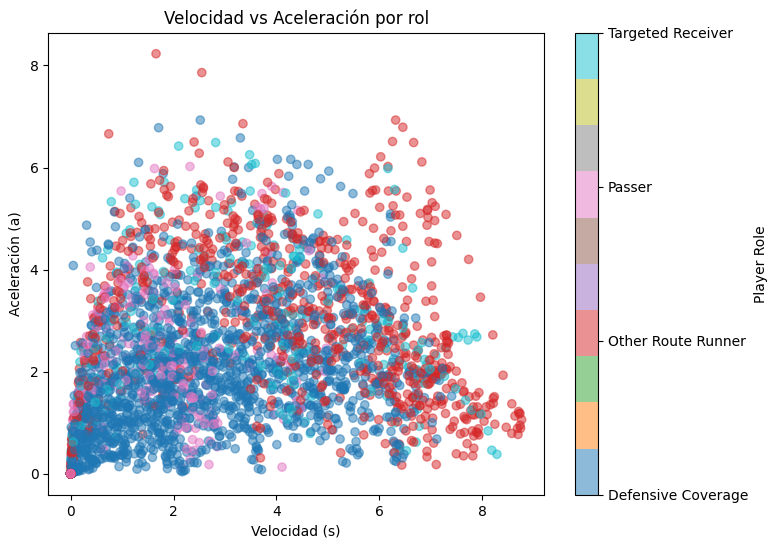

In [11]:
"""
La siguiente gráfica nos ayuda a comparar la velocidad y aceleración de los jugadores en base
a su rol en el equipo, imporante a considerar ya que genera mayor variación en la posición
del jugador en el campo de juego.
"""
import numpy as np
subset2 = X2.sample(3000).to_pandas()

plt.figure(figsize=(8,6))
sc = plt.scatter(
    subset['s'],
    subset['a'],
    c=subset['player_role'],
    cmap="tab10",
    alpha=0.5
)

# Ajustamos la barra de colores para categorías (no continua)
cbar = plt.colorbar(sc, ticks=np.arange(len(mappings['player_role'])))
cbar.ax.set_yticklabels(mappings['player_role'].keys())  # nombres en vez de números
cbar.set_label("Player Role")

plt.xlabel("Velocidad (s)")
plt.ylabel("Aceleración (a)")
plt.title("Velocidad vs Aceleración por rol")
plt.show()

<Axes: >

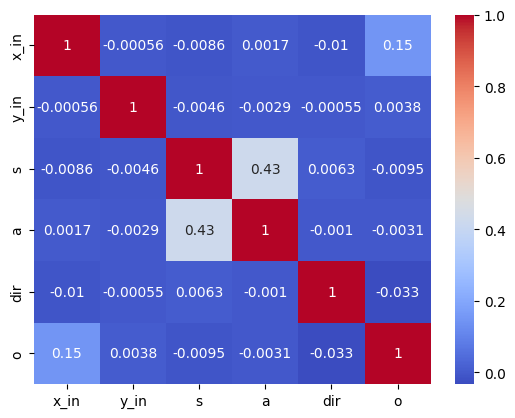

In [12]:
"""
El siguiente cuadro enseña la correlación entre variables físicas importantes como
la posición en X y Y, la velocidad, aceleración, orientación y distancia.
"""
import seaborn as sns
corr = train_full[['x_in','y_in','s','a','dir','o']].to_pandas().corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [13]:
!pip install hvplot
import hvplot.cudf
clear_output()

In [14]:
"""
En el último diagrama tenemos un mapa de calor con el conteo de jugadores en
posiciones específicas del campo de juego. Mostrando la acumulación en el
centro y la dispersión hacia los extremos.
"""
train_full.hvplot.hexbin(x='x_in', y='y_in', gridsize=50)

:HexTiles   [x_in,y_in]

In [15]:
"""
Para esta gráfica tomamos una jugada del dataset, filtramos la dirección del juego
e imprimimos la posición de los jugadores en esa jugada respecto al campo, mostrando
su comportamiento de acuerdo a su dirección.
"""
play = X2[X2['play_id'] == 101].copy()
direction_label = "Derecha" if play["play_direction"].iloc[0] == 1 else "Izquierda"
print(f"Dirección del juego: {direction_label}")
play.hvplot.scatter(x='x', y='y', title='Posición de los jugadores en el juego')

Dirección del juego: Derecha


:Scatter   [x]   (y)

#Punto #4.2: Modelo
Luego, utilizando un esquema de validacion hold-out con una partición del 60% para entrenamiento, 20 % para validacion y 20% para evaluación del rendimiento, compare los regresores mencionados en el punto 2 —considerando sus posibles implementaciones en RAPIDS, segun lo indicado en el punto 3—, empleando el conjunto de datos de entrenamiento disponible en el dataset.
Realice las consideraciones necesarias para la implementacion y sintonización de cada modelo mediante optimización bayesiana, con el fin de determinar los hiperparámetros más relevantes de cada algoritmo. Justifique la selección de los hiperparámetros a optimizar, así como la rejilla o los rangos de valores definidos para cada modelo, de acuerdo con las características estudiadas
y el score a minimizar. Finalmente, presente los rendimientos promedio obtenidos sobre el conjunto de evaluacion, junto con su respectiva desviación estándar, empleando las siguientes métricas de desempeño: MAE, MSE, R2 (consultar) y MAPE (consultar).

In [33]:
# Partición de los datos del dataset arreglado y filtrado
from cuml.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
  train_full, targets, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
  X_train_val, y_train_val, test_size=0.25, random_state=42)

In [34]:
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (336256, 18)
Validation: (112085, 18)
Test: (112085, 18)


In [35]:
# Organización del conjutno de datos para su uso en Optuna
X_train, y_train = X_train.iloc[:, :-1], X_train.iloc[:, -1]
X_val, y_val = X_val.iloc[:, :-1], X_val.iloc[:, -1]
X_test, y_test = X_test.iloc[:, :-1], X_test.iloc[:, -1]

In [40]:
!pip install optuna
import optuna
import pandas as pd
import numpy as np
from functools import partial
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

clear_output()

In [2]:
from cuml.linear_model import LinearRegression, Lasso, ElasticNet
from cuml.svm import SVR
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from cuml.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Helper: safe MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-10, None))) * 100

def prepare_data_for_model(model, X, y):
  model_type = str(type(model)).lower()
  if "cuml" in model_type or "xgb" in model_type:  # RAPIDS or XGBoost GPU
    return X, y  # cuDF/CuPy data is fine
  else:  # scikit-learn (CPU)
    return X.to_pandas().to_numpy(), y.to_pandas().to_numpy()

# List of regressors
regressors = {
  "LinearRegression": LinearRegression(),
  "Lasso": Lasso(),
  "ElasticNet": ElasticNet(),
  "SGDRegressor": SGDRegressor(),
  "BayesianRidge": BayesianRidge(),
  "GaussianProcessRegressor": GaussianProcessRegressor(),
  "SVR": SVR(),
  "RandomForestRegressor": RandomForestRegressor(),
  "XGBRegressor": XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor')
}

In [3]:
def run_optuna_for_models(X_train, y_train, X_val, y_val, model_names, n_trials=30):
  def objective(trial, model_name):
    # --- Model definitions ---
    if model_name == "LinearRegression":
      model = LinearRegression()
    elif model_name == "Lasso":
      model = Lasso(
        alpha=trial.suggest_float("alpha", 1e-4, 10.0, log=True),
        max_iter=10000
      )
    elif model_name == "ElasticNet":
      model = ElasticNet(
        alpha=trial.suggest_float("alpha", 1e-4, 10.0, log=True),
        l1_ratio=trial.suggest_float("l1_ratio", 0.0, 1.0),
        max_iter=10000
      )
    elif model_name == "BayesianRidge":
      model = BayesianRidge(
        alpha_1=trial.suggest_float("alpha_1", 1e-7, 1e-3, log=True),
        lambda_1=trial.suggest_float("lambda_1", 1e-7, 1e-3, log=True)
      )
    elif model_name == "SVR":
      model = SVR(
        C=trial.suggest_float("C", 0.1, 100.0, log=True),
        epsilon=trial.suggest_float("epsilon", 1e-3, 1.0, log=True),
        kernel=trial.suggest_categorical("kernel", ["linear", "rbf", "poly"])
      )
    elif model_name == "RandomForestRegressor":
      model = RandomForestRegressor(
        n_estimators=trial.suggest_int("n_estimators", 50, 300),
        max_depth=trial.suggest_int("max_depth", 3, 30),
        n_streams=8
      )
    elif model_name == "XGBRegressor":
      model = XGBRegressor(
        n_estimators=trial.suggest_int("n_estimators", 50, 300),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        max_depth=trial.suggest_int("max_depth", 2, 10),
        tree_method='gpu_hist',
        predictor='gpu_predictor'
      )
    elif model_name == "SGDRegressor":
      model = SGDRegressor(
        alpha=trial.suggest_float("alpha", 1e-5, 1e-1, log=True),
        penalty=trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet"]),
        max_iter=1000
      )
    elif model_name == "GaussianProcessRegressor":
      model = GaussianProcessRegressor(alpha=trial.suggest_float("alpha", 1e-10, 1e-2, log=True))
    else:
      raise ValueError(f"Unknown model name: {model_name}")

    # --- Prepare data ---
    X_t, y_t = prepare_data_for_model(model, X_train, y_train)
    X_v, y_v = prepare_data_for_model(model, X_val, y_val)

    model.fit(X_t, y_t)
    y_pred = model.predict(X_v)

    # --- Convert to CPU (NumPy) if GPU data ---
    if hasattr(y_pred, "to_numpy"):
      y_pred = y_pred.to_numpy()
    if hasattr(y_v, "to_numpy"):
      y_v = y_v.to_numpy()

    mse = mean_squared_error(y_v, y_pred)
    return mse
  # --- Main loop ---
  results = {}

  for name in model_names:
    print(f"\n🚀 Optimizing {name} ...")
    study = optuna.create_study(direction="minimize")
    study.optimize(partial(objective, model_name=name), n_trials=n_trials)

    best_params = study.best_params
    print(f"Best params for {name}: {best_params}")

    # --- Rebuild the best model directly ---
    if name == "LinearRegression":
        model = LinearRegression()
    elif name == "Lasso":
        model = Lasso(**best_params)
    elif name == "ElasticNet":
        model = ElasticNet(**best_params)
    elif name == "BayesianRidge":
        model = BayesianRidge(**best_params)
    elif name == "SVR":
        model = SVR(**best_params)
    elif name == "RandomForestRegressor":
        model = RandomForestRegressor(**best_params)
    elif name == "XGBRegressor":
        model = XGBRegressor(**best_params)
    elif name == "SGDRegressor":
        model = SGDRegressor(**best_params)
    elif name == "GaussianProcessRegressor":
        model = GaussianProcessRegressor(**best_params)
    else:
        raise ValueError(f"Unknown model name: {name}")

    # Continue with fitting and metrics
    X_t, y_t = prepare_data_for_model(model, X_train, y_train)
    X_v, y_v = prepare_data_for_model(model, X_val, y_val)

    model.fit(X_t, y_t)
    y_pred = model.predict(X_v)

    # --- Safe conversions ---
    if hasattr(y_pred, "to_numpy"):
        y_pred = y_pred.to_numpy()
    if hasattr(y_v, "to_numpy"):
        y_v = y_v.to_numpy()

    # --- Metrics ---
    mae = mean_absolute_error(y_v, y_pred)
    mse = mean_squared_error(y_v, y_pred)
    r2 = r2_score(y_v, y_pred)
    mape = mean_absolute_percentage_error(y_v, y_pred)

    results[name] = {
        "Best Params": best_params,
        "MAE": mae,
        "MSE": mse,
        "R2": r2,
        "MAPE (%)": mape
    }

  return pd.DataFrame(results).T.sort_values("MSE")

In [4]:
results_df = run_optuna_for_models(X_train, y_train, X_val, y_val, regressors, n_trials=20)

NameError: name 'X_train' is not defined